<span style="color:#A00;font-weight:bold">Missing data: this notebook relies on calibration FITS files from Nickel. The files are not provided.</span>

## Source extraction

*Overscan bias correction, filters, star recognition, point-spread functions, 2D centroiding*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# This is new! "patches" will allow us to annotate images rendered by plt.imshow()
import matplotlib.patches as patches

from astropy.io import fits
import os

%matplotlib inline

In astronomy, *source extraction* refers to the process where astronomical objects (stars, galaxies, etc) appearing in an image are automatically recognized and their basic parameters, such as their $X$ and $Y$ pixel positions and instrumental brightness, are determined. This notebook will demonstrate source extraction using the basic dataset from the Nickel telescope posted on TritonEd as an example.

<br>
<div class="alert alert-warning">
    As with spectroscopy, the mechanism has a lot of moving parts and may not work on a different dataset without some alterations. As such, students are encouraged to run this notebook on the basic dataset first and proceed to their own data only once a sufficient level of understanding is achieved.
</div>

In [2]:
data_dir = '../../NICKEL_data/'
data_files = np.array(os.listdir(data_dir))

## Arbitrary argument lists

Before we start, I would like to present an elegant feature in Python that may be useful later. *Arbitrary argument lists* allow us to define functions that accept a variable number of arguments. As always, have a look at the example below and try to understand what is going on. We will see a more practical example in a moment...

In [3]:
# "*" means that this function will work with any set of arguments. Within the function, they will be available as
# items of the list called "numbers" (well, technically this is a tuple; not a list)
def my_func(*numbers):
    """ Prints all passed arguments """
    print "You passed {} argument(s)".format(len(numbers))
    print "Here they all are:", numbers

# Now we can feed any arguments we want into this function and it will print all of them back
my_func(1)
my_func(1, 2)
my_func(1, 2, 3)

# The reverse can also be done. It is possible to save all arguments to be passed into a function as a list
# and use "*" to "unpack" them
my_list = [1, 2, 3, 4]
my_func(*my_list)

You passed 1 argument(s)
Here they all are: (1,)
You passed 2 argument(s)
Here they all are: (1, 2)
You passed 3 argument(s)
Here they all are: (1, 2, 3)
You passed 4 argument(s)
Here they all are: (1, 2, 3, 4)


Now let's write a function that loads FITS headers. Using arbitrary argument lists, it is possible to allow the caller to specify the headers they want as arguments:

In [4]:
def load_headers(*headers):
    """ Load a set of FITS headers from all files. Relies on global variables data_dir and data_files """
    
    # All loaded headers will be saved here. np.full() creates a NumPy array of a given shape (first argument)
    # filled with a constant value (second argument, empty string in this case). "dtype = object" will allow
    # the array to store data of any type (some headers may be numbers, not strings).
    output = np.full([len(headers), len(data_files)], "", dtype = object)
    
    # Now read the headers from all files
    for i, data_file in enumerate(data_files):
        h = fits.open(data_dir + data_file)
        for j, header_name in enumerate(headers):
            output[j, i] = h[0].header[header_name]
        h.close()
    return output

# Test drive the function
obstypes, objects, exptimes = load_headers('OBSTYPE', 'OBJECT', 'EXPTIME')

print "OBSTYPE:", obstypes
print "OBJECT:", objects
print "EXPTIME:", exptimes

OBSTYPE: ['OBJECT' 'OBJECT' 'OBJECT' 'OBJECT' 'OBJECT' 'OBJECT' 'OBJECT' 'OBJECT'
 'OBJECT' 'OBJECT' 'OBJECT' 'OBJECT']
OBJECT: ['flat' 'flat' 'flat' 'flat' '109_954' '109_954' '109_954' '109_954'
 'PSN22+40' 'PSN22+40' 'PSN22+40' 'PSN22+40']
EXPTIME: [4.0 9.0 12.0 40.0 40.0 20.0 10.0 10.0 180.0 150.0 120.0 120.0]


## Data reduction

The headers reveal that we are dealing with 8 science images of two objects (Landolt 109 954 aka [SA 109-954](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=SA+109-954&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) and PSN22+40 in [NGC 7250](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=NGC+7250&submit=SIMBAD+search)) and 4 flat fields. So far in this course we have been mostly overlooking that most astronomical observations are taken through a specific filter. This dataset contains images taken through different filters, so this fact can no longer be ignored. The filter used for every observation can be found in the FITS headers:

In [5]:
filters = load_headers('FILTNAM')[0]
print filters

['B' 'V' 'R' 'I' 'B' 'V' 'R' 'I' 'B' 'V' 'R' 'I']


<div class="alert alert-info">
    <b>FYI:</b> <code>B</code>, <code>V</code>, <code>R</code> and <code>I</code> here refer to the standard <i>Johnson-Cousins</i> photometric filter set, named after Harold Johnson and Alan Cousins. Johnson was a mid-XX century pioneer of high-precision photometry (brightness measurements) who defined and calibrated the first widely recognized standard filter set. The original Johnson 1953 set included <code>U</code>, <code>B</code> and <code>V</code>, but was extended in 1966 to also include <code>R</code>, <code>I</code>, <code>J</code>, <code>K</code>, <code>L</code> filters.<br><br>

Here <code>B</code> stands for "blue", <code>R</code> stands for red, <code>V</code> for "visual" (green), <code>U</code> for near-ultraviolet, <code>I</code> for near-infrared and <code>J</code>, <code>K</code> and <code>L</code> lie in further infrared. While the high frequency filters (<code>U</code>, <code>B</code> and <code>V</code>) performed well, the low frequency filters in the Johnson set could not be reliably calibrated with the detectors available at the time. Fortunately, the situation changed only a decade later with Cousins being among the first to take advantage of the new generation of photomultipliers to refine the definitions of <code>R</code> and <code>I</code> in his 1976 publication.<br><br>

The standard Johnson-Cousins set has been tuned multiple times since 1976, particularly in the advent of CCD detectors; however, the original transmission profiles defined by Johnson and Cousins still form the basis of most modern filter sets and are considered a universally accepted standard to this day.
</div>

When an observation is carried out, the filter is placed directly in the way of light, meaning that each filter will call for its own flat field. It is very important that, say, <code>R</code> science frames are reduced with <code>R</code> flat fields; <code>V</code> science frames are reduced with <code>V</code> flat fields and so forth.

You may have also noticed that the basic dataset is missing bias frames. Fortunately, the CCD used for those observations has an overscan region. We encountered overscanning briefly in the previous lab, where we cut out the overscan region entirely. In this lab, however, the overscan region comes in handy, as one can use it to determine the bias level. Let's start by opening the first flat field to see what is going on:

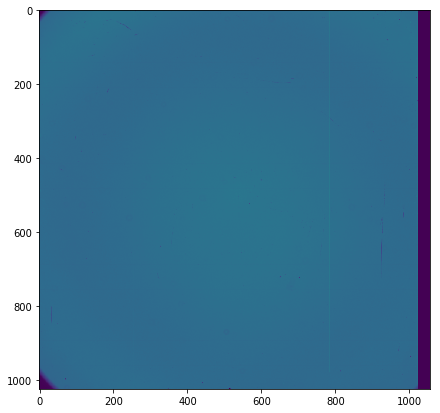

In [6]:
first_flat = data_files[objects == 'flat'][0]
h = fits.open(data_dir + first_flat)
data = h[0].data * 1.0
h.close()

plt.figure(figsize = [7, 7])
plt.imshow(data)

The overscan region is the low-count stripe on the right. The width of the region can be read from the FITS headers:

In [7]:
overscans = load_headers('COVER')[0]
print overscans

[32 32 32 32 32 32 32 32 32 32 32 32]


<div class="alert alert-info">
    The overscan bias is generally inferior to a full bias frame, as it only captures bias in one dimension (there exist CCDs with both horizontal and vertical overscan regions, but even then the full 2D map of pixel bias cannot be fully reconstructed). Nonetheless, there is a significant advantage to overscan bias over bias frames (apart from convenience): overscan bias is recorded at the same time as the rest of the frame, thereby preventing any errors due to temporal variations in the bias level.
</div>

We now proceed to create a function that will load any FITS file for us, automatically correcting it for bias encoded in the overscan region:

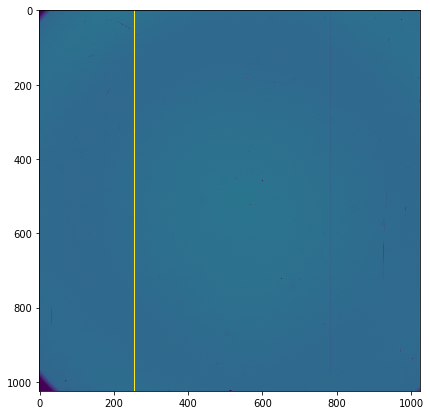

In [8]:
def load_frame(filename):
    """ I need a docstring """
    h = fits.open(data_dir + filename)
    data = h[0].data * 1.0
    h.close()
    
    # Determine the width of the overscan region
    overscan_width = overscans[data_files == filename][0]
    
    # Slice the image into two parts: one for the image itself and one for the overscan
    image = data[:, :-overscan_width]
    overscan_region = data[:, -overscan_width:]
    
    # If there are multiple overscan columns, we can average them all to obtain the best estimate of bias
    bias_per_row = np.mean(overscan_region, axis = 1) # "axis=1" means "average across rows only"
    
    #################
    # Write your own code here to carry out the bias correction. You will have to make the shape of
    # bias_per_row match the shape of image. You may want to look into np.vstack(). Of course, there are
    # many other ways of doing this. It is however strongly recommended to avoid for-loops and use
    # NumPy array operations for efficiency.
    #################
    
    
    return image
    
data = load_frame(first_flat)
plt.figure(figsize = [7, 7], facecolor = 'w')
plt.imshow(data)

<div class="alert alert-warning">
    As we have seen in the previous lab, the data may contain multiple amplifiers as well as horizontal overscan regions. The code cell above should probably be modified to account for these possibilities, even though they are not realized in this particular dataset. You can find more about this in the "Single slit spectroscopy" notebook on TritonEd.
    <br><br>
    Our bias subtraction also failed to account for the obviously defective pixel columns that may make our lives harder further down the line. Can you think of a way to correct for those rows without bias?
</div>

With bias taken care off, we now need a function to load science frames and flat-field them, making sure that flat fields of the same filter are used:

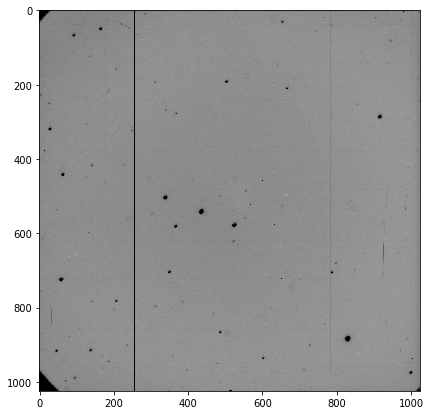

In [12]:
# This function was taken from the previous computing session
def compute_master_frame(data_files):
    """ I still need a docstring """
    master = None
    for data_file in data_files:
        single = load_frame(data_file)
        if master is None:
            master = single
        else:
            master += single
    master /= len(data_files)
    return master

def load_reduced_frame(filename):
    """ I need a docstring """
    # Determine the filter used
    filt = filters[data_files == filename][0]
    
    # Find all flats that correspond to this filter
    flats = data_files[(objects == 'flat') & (filters == filt)]
    
    # Compute master flat
    master_flat = compute_master_frame(flats)
    
    # Load and reduce the science frame
    data = load_frame(filename)
    data /= (master_flat / np.median(master_flat))
    
    return data


# Test-drive the function on one of the science frames
first_science = data_files[objects != 'flat'][3]
data = load_reduced_frame(first_science)

plt.figure(figsize = [7, 7])

# np.median(data) is a good estimate of the sky brightness. I set the ceiling to be 1.5 times brighter than that.
plt.imshow(data, vmax = np.median(data) * 1.5, cmap = "Greys")

To avoid running the same routine over and over again we can save the reduced image in a separate FITS file.

In [13]:
# Name of the file to store the reduced image
new_file = data_dir + first_science[:-5] + '-REDUCED.fits'

# If the file already exists, remove it
if (os.path.isfile(new_file)):
    os.remove(new_file)
    print "Warning: Previous instance of {} has been overwritten!".format(new_file)

# To avoid writing all FITS headers from scratch, we can take the raw image and simply change
# what we want
h = fits.open(data_dir + first_science)
h[0].data = data
h[0].header["BZERO"] = 0    # This is necessary to make sure AstroPy does not add an offset to our data
h[0].header["COMMENT"] = "Flat-fielded, corrected for overscan bias"  # Add explanatory comment
h.writeto(new_file)
h.close()

## Object recognition

Load the saved image back:

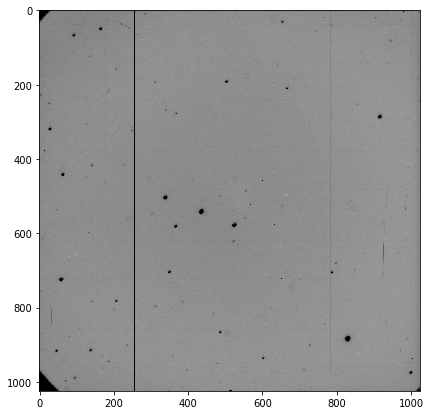

In [14]:
h = fits.open(new_file)
data = h[0].data * 1.0
h.close
plt.figure(figsize = [7, 7])
plt.imshow(data, vmax = np.median(data) * 1.5, cmap = "Greys")

The image above contains a few stars that we are trying to extract. To write an algorithm that can recognize stars automatically, we first need to come up with a practical definition of what constitutes a star in the first place.

At this point, you are encouraged to employ your creativity to come up with your own way of accomplishing this task. What follows is merely my attempt that happens to work on this dataset, but is not guaranteed to be universal or efficient. My practical definition of a star involves a few criteria:

* **Stars are bright**. Well, they sure thing are brighter than the sky. The sky signal can be estimated by taking the median across the entire frame (why?). I would suspect any pixel that is at least twice as bright to belong to a star.
* **Stars are not points**. As you may be able to see in the image above, stars are much bigger than a single pixel, primarily due to atmospheric effects. The 2D profile of a star is sometimes referred to as the *point-spread-function* or PSF. Usually, PSFs of stars are well-approximated by the 2D Gaussian function. If my suspect bright pixel is indeed a star, it would probably have at least 10 or so bright pixels in its vicinity. If my pixel is alone in its part of the sky, it is almost certainly a defect and not a star (e.g. a cosmic ray impact).
* **Stars are roughly symmetric**. Of course, nothing is perfect given the noise level; however, I would not expect my stars to be stretched out either vertically or horizontally by too much. A highly asymmetric object is either a defect (e.g. a bad column) or an object of a different kind (galaxies, nebulae etc).
* **Stars have local maxima**. Just like spectral lines, somewhere within the PSF of the star will be a local maximum, albeit in two dimensions instead of one.

The code cell below attempts to identify stars in the loaded science frame. As always, it relies on a lot of free parameters that you can and should experiment with.

C:\Users\Roman\AppData\Roaming\Python\Python27\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


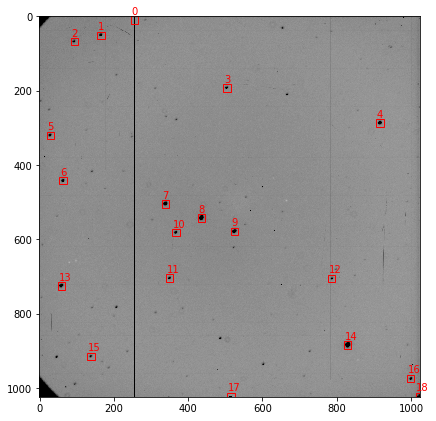

In [15]:
bright_threshold = np.median(data) * 1.5     # My stars are made of pixels brighter than the sky by a factor of 2

# Find all those "suspect" pixels
bright_pxs = np.array(np.where(data > bright_threshold)).T

# We will search for stars as local maxima and save the ones we find here
local_maxima = []

# Neighbourhood size. A pixel must be larger than all pixels within this interval to be considered a local maximum.
n_size = 10


# Iterate over every suspect pixel and check if it belongs to a star...
for bright_px in bright_pxs:
    
    # Get the neighbourhood
    neighbourhood = data[bright_px[0] - n_size:bright_px[0] + n_size, bright_px[1] - n_size:bright_px[1] + n_size]
    
    # When too close to the edge, the neighbourhood may evaluate to an empty array. Assume there are no stars
    # so close to the edge of the frame
    if np.size(neighbourhood) == 0:
        continue
    
    # How many other bright pixels are there in the neighbourhood? If fewer than 10, this pixel is unlikely
    # to belong to a star. Stars are PSFs, not points.
    bright_count = len(neighbourhood[neighbourhood > bright_threshold])
    if bright_count < 10:
        continue
    
    # Compute the "width" and the "height" of the star
    n_bright_pxs = np.where(neighbourhood > bright_threshold)
    star_width = max(n_bright_pxs[0]) - min(n_bright_pxs[0])
    star_height = max(n_bright_pxs[1]) - min(n_bright_pxs[1])
    # Calculate the elongation of the star as the ratio of width to height (or vice versa)
    star_elongation = min(star_width, star_height) / float(max(star_height, star_width))
    # If the "star" is too elongated, it probably isn't a star...
    if star_elongation < (1 / 3.0):
        continue
    
    # Finally, we need to be brighter than all our neighbours to be a local maximum
    if (data[bright_px[0], bright_px[1]] >= np.max(neighbourhood)):
        local_maxima += [[bright_px[0], bright_px[1]]]

plt.figure(figsize = [7, 7])
plt.imshow(data, vmax = np.median(data) * 1.5, cmap = "Greys")

# Iterate over all found local maxima, label them and draw squares around them using matplotlib.patches
for i, local_maximum in enumerate(local_maxima):
    plt.axes().add_patch(patches.Rectangle([local_maximum[1] - 10, local_maximum[0] - 10], 20, 20, fill=False, color = 'r'))
    plt.text(local_maximum[1] - 8, local_maximum[0] - 15, str(i), color = 'r')

The algorithm seems to have worked, recognizing most of the stars in the image. However, a closer look will reveal some stars that are missed and others that are misidentified and are not stars at all. The algorithm leaves a lot of room for improvement and the students are highly encouraged to fill it in.

## PSFs and centroids

Just like in the previous lab, local maxima only approximate the true positions of stars. We are primarily interested in their centroids, defined as the weighted averages of coordinates.

Before we calculate those, let us have a look at a typical PSF of a star. The full PSF would inevitably have two dimensions; nonetheless, we can get a "taste" of it by taking a horizontal profile.

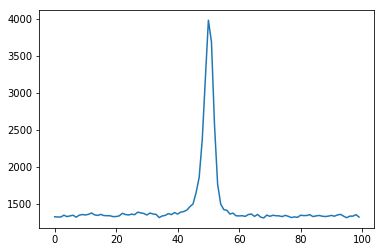

In [16]:
test_star = local_maxima[6]  # One of our stars.


profile = data[test_star[0] - 50 : test_star[0] + 50, test_star[1]]
pos = np.array(range(len(profile)))

# Needs labels!
plt.plot(pos, profile)

The most important property of the PSF is its full-width-at-half-maximum (FWHM). This parameter is the effective limit on the resolution of the instrument (two objects that are closer to each other than their FWHMs are practically impossible to resolve). Furthermore, the FWHM will tell us how wide the region need to be, within which we will be calculating centroids.

Note that stars themselves can be assumed infinitely small point-sources (there are extreme [exceptions](https://en.wikipedia.org/wiki/List_of_stars_with_resolved_images) to this). Hence, the FWHM is dominated by instrumental and atmospheric effects, where the latter is usually considerably more significant for ground-based observatories. This implies that we expect the FWHM to be approximately the same for all stars (in fact, we could use this to test, whether an object is a star!).

The code cell below will proceed with our test star and compute the FWHM of its PSF. Students are expected to rewrite the cell to compute the average FWHM across all stars instead and reject those that have too large / small FWHMs.

In [17]:
half_max = np.max(profile) / 2.0
outside = profile < half_max
FWHM = min(pos[outside & (pos > 50)]) - max(pos[outside & (pos < 50)])
print "Full-Width-at-Half-Maximum: {} pixels".format(FWHM)

Full-Width-at-Half-Maximum: 6 pixels


As opposed to spectral lines, stars are usually more spread out, leaving a lot of empty space in between. That being said, there most definitely exist groups of stars that are very close to each other and this assumption no longer holds, so one needs to be careful! Ignoring those close groups for now, we should be able to compute centroids within generous "catching" regions around local maxima of a few FWHMs. In the cell below, I will be calculating centroids within 5 FWHM of every star.

Centroids are nothing more than intensity-weighted average positions. The relevant equations are:

$$ x_c = \sum_p{\frac{p_x I(p)}{I(p)}} \ \ \ \ \ \ \ \ \ y_c = \sum_p{\frac{p_y I(p)}{I(p)}}$$

Here $p$ is a set of all pixels within the "catching" region (in my case, within 5 FWHMs of the local maximum), each having an $x$ and a $y$ coordinates ($p_x$ and $p_y$ respectively) and $I(p)$ is the flux (in ADUs) at the pixel.

The catching region will inevitably contain a lot of sky pixels as well that do not belong to a star. To avoid any offsets due to those, it is also sometimes advised to include those pixels in $p$ that pass a certain brightness threshold (e.g. twice the median value, as we assumed before).

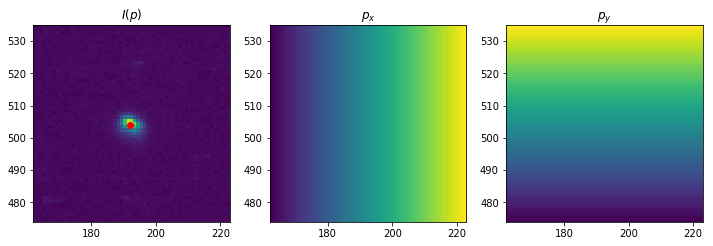

In [18]:
region_size = FWHM * 5     # Size of the catching region

centroids = []             # Save all determined centroids here

for i, lm in enumerate(local_maxima):
    # Get the flux within the catching region
    I = np.array(data[lm[0] - region_size : lm[0] + region_size + 1, lm[1] - region_size : lm[1] + region_size + 1])
    # If too close to the edge, "I" may end up empty. If so, ignore this local maximum
    if np.size(I) == 0:
        continue
    # Apply the brightness threshold. Remember that we use "I" as weights, so "0" would mean "ignore this pixel"
    I[I < np.median(I) * 2.0] = 0
    
    # Now determine the x and y pixel coordinates of every pixel in the catching region
    x = np.vstack([range(lm[0] - region_size, lm[0] + region_size + 1)] * np.shape(I)[1])
    y = np.vstack([range(lm[1] - region_size, lm[1] + region_size + 1)] * np.shape(I)[0]).T
    
    # If the shapes of those do not match the shape of "I", we are, again, too close to the edge.
    if np.shape(I) != np.shape(x) or np.shape(I) != np.shape(y):
        continue
    
    ######################
    # The line below pushes the local maximum coordinates into "centroids". Replace this line
    # with your calculation of the centroid coordinates, using "I", "x" and "y".
    centroids += [[lm[0], lm[1]]]
    ######################
    
    # Plot x, y and I for some arbitrary star (change i==3 to something else to see others!)
    # If your centroiding above is correct, you should see a red dot appear over the centroid!
    if i == 3:
        figure, axes = plt.subplots(1, 3, figsize = [12, 4])
        extent = [lm[0] - region_size, lm[0] + region_size + 1, lm[1] - region_size, lm[1] + region_size + 1]
        axes[0].imshow(data[extent[0] : extent[1], extent[2] : extent[3]], extent = extent, origin = "lower")
        axes[1].imshow(x, extent = extent, origin = "lower")
        axes[2].imshow(y, extent = extent, origin = "lower")
        axes[0].set_title("$I(p)$")
        axes[1].set_title("$p_x$")
        axes[2].set_title("$p_y$")
        axes[0].plot(centroids[-1][0], centroids[-1][1], 'ro')
        for i in range(2):
            axes[i].set_xlim(extent[0], extent[1]);axes[i].set_ylim(extent[2], extent[3])

<div class="alert alert-warning">
    We assume that the catching region is a rectangle. PSFs of stars usually have circular symmetry and, perhaps, a circular catching region is a better choice!
</div>

Plot all calculated centroids:

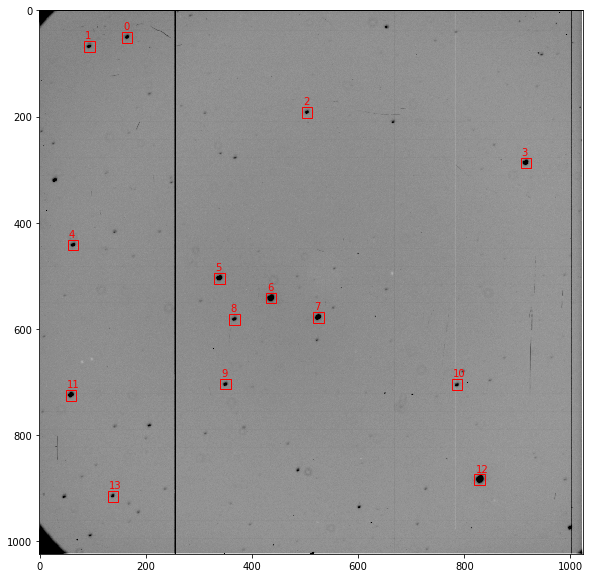

In [20]:
plt.figure(figsize = [10, 10])
plt.imshow(data, vmax = np.median(data) * 1.5, cmap = "Greys")

for i, centroid in enumerate(centroids):
    plt.axes().add_patch(patches.Rectangle((centroid[1] - 10, centroid[0] - 10), 20, 20, fill=False, color = 'r'))
    plt.text(centroid[1] - 8, centroid[0] - 15, str(i), color = 'r')

For future reference, we can now save the identified centroids in a text file:

In [69]:
np.savetxt('my_centroids.dat', centroids)